# 02_NYC_data_generator

## NOTE: This notebook is currently incomplete. 

## An updated version will be pushed to the GitHub repo once it is complete

Member of the team:
- An Hoang
- Michael Sedelmeyer
- Mark McDonald


### Inputs:

**1. ../data/interim/Capital_Projects_clean.csv**

A cleansed version of the Capital_Projects.csv file, wherein each record represents one project change.

### Outputs:

**1. ../data/interim/.csv**

A version of the Capital_Projects.csv file, wherein each record represents one unique project with summary information regarding all associated project changes.

## Notebook Index

<a name='index'></a>

### 1) Notebook Setup 
&emsp; &emsp; <a href=#imports>Imports</a>  // <a href=#helpers>Helper Functions</a> // <a href=#read>Read Dataset</a>

### 2) Analysis

#### &emsp; &emsp; a) <a href=#cleanup>Data Cleanup</a>

#### &emsp; &emsp; b) <a href=#counts>Counts</a>

#### &emsp; &emsp; c) <a href=#trends>Trends</a>

#### &emsp; &emsp; d) <a href=#budget>Budget Values</a>

#### &emsp; &emsp; e) <a href=#missing>"Missing-ness"</a>

#### &emsp; &emsp; f) <a href=#summary>Summary & Findings</a>

#### &emsp; &emsp; g) <a href=#open>Open Items / Unanswered</a>

### 3) Save dataframes to .csv
&emsp; &emsp; <a href=#save>Save dataframes to CSV</a>

<a name='imports'></a>

## Imports
Imports for function used in this notebook.

<a href=#index>index</a>

In [1]:
import os
import math
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format
import logging

# Improve resolution of output graphcis
%config InlineBackend.figure_format ='retina'

<a name='helpers'></a>
## Helper Functions
Functions used to accomplish repeated tasks in this notebook.

<a href=#index>index</a>

### Matplotlib Helper Functions

In [2]:
def plot_hist_comps(df, metric_1, metric_2, y_log=False, bins=20):
    """Plots side-by-side histograms for comparison with log yscale option 
    """
    metrics_list = [metric_1, metric_2]
    metrics_str = [
        metric.replace('_', ' ').upper() for metric in metrics_list
    ]
    
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
    
    plt.suptitle(
        'Projects by {} and {}'.format(*metrics_str),
        fontsize=18
    )
    
    for (i, ax), metric_col, metric_name in zip(enumerate(ax), metrics_list, metrics_str):
        ax.hist(df[metric_col], bins=bins, alpha=0.7)
        ax.axvline(df[metric_col].mean(), color='k', label='mean')
        ax.axvline(df[metric_col].quantile(q=.5), color='k', linestyle='--', label='median')
        ax.axvline(df[metric_col].quantile(q=.025), color='k', linestyle=':', label='95% range')
        ax.axvline(df[metric_col].quantile(q=.975), color='k', linestyle=':')

        ax.set_xlabel(metric_name, fontsize=14)
        ax.grid(':', alpha=0.4)
        if i==0:
            ax.set_ylabel('frequency', fontsize=12)
            ax.legend(fontsize=12)
        if y_log:
            ax.set_yscale('log')
            if i==0:
                ax.set_ylabel('frequency (log scale)', fontsize=12)
            
    
    plt.tight_layout(rect=[0, 0.03, 1, .94])
    plt.show()

In [3]:
def plot_change_trend(trend_data, pid_data, pid):
    """Plots 4 subplots showing project budget and duration forecast change trend
    """
    # sets default for converting datetimes in matplotlib
    from pandas.plotting import register_matplotlib_converters
    from matplotlib.dates import YearLocator, DateFormatter
    register_matplotlib_converters()
    
    years = YearLocator()
    years_fmt = DateFormatter('%Y')
    
    def set_date_axis(ax, years, years_fmt):
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(years_fmt)
    
    fig, ax = plt.subplots(2,2, sharex=True, figsize=(12,6))
    
    pid_record = pid_data.loc[pid_data['PID']==pid]
    pid_changes = trend_data.loc[trend_data['PID']==pid]

    project_duration = pid_record['Original_Duration'].values[0] + \
                       np.cumsum(pid_changes['Latest_Schedule_Changes'].values)

    plt.suptitle(
        'PID {}: {}\nCategory: {}\nBorough: {}\ninitial duration: {:,.0f} days'.format(
            pid,
            pid_record['Project_Name'].values[0][:72],
            pid_record['Category'].values[0],
            pid_record['Borough'].values[0],
            pid_record['Original_Duration'].values[0]
        ), fontsize=16
    )

    # plot budget forecast
    ax[0,0].plot(
        pid_changes['Date_Reported_As_Of'], pid_changes['Budget_Forecast']/1e7, 'ko-'
    )
    ax[0,0].set_title('Total budget forecast')
    ax[0,0].set_ylabel('USD (millions)')

    # plot budget forecast percent change
    ax[1,0].plot(
        pid_changes['Date_Reported_As_Of'],
        ((pid_changes['Latest_Budget_Changes'])/
        (pid_changes['Budget_Forecast']-pid_changes['Latest_Budget_Changes']))*100,
        'ko-'
    )
    ax[1,0].axhline(0, color='k', linestyle=':')
    ax[1,0].set_title('Percentage budget change')
    ax[1,0].set_ylabel('percent change')

    ax[1,0].set_xlabel('project change date')

    # plot duration forecast
    ax[0,1].plot(
        pid_changes['Date_Reported_As_Of'], project_duration/1e3, 'ko-'
    )
    ax[0,1].set_title('Total forecasted project duration')
    ax[0,1].set_ylabel('days (thousands)')

    # plot duration change
    ax[1,1].plot(
        pid_changes['Date_Reported_As_Of'],
        (pid_changes['Latest_Schedule_Changes'] /
        (project_duration - pid_changes['Latest_Schedule_Changes']))*100,
        'ko-'
    )
    ax[1,1].axhline(0, color='k', linestyle=':')
    ax[1,1].set_title('Percentage duration change')
    ax[1,1].set_ylabel('percent change')
    
    ax[1,1].set_xlabel('project change date')
    
    for a in ax.flat:
        a.grid(':', alpha=0.4)
        set_date_axis(a, years, years_fmt)
    
    plt.tight_layout(rect=[0, 0.03, 1, .81])
    plt.show()


<a name='read'></a>
## Read Dataset
Read the dataset and perform basic manipulation of headers and some fields including formatting.

<a href=#index>index</a>

In [4]:
predict_interval = 3 # number of years

file_path = '../data/interim/Capital_Projects_clean.csv'
save_path = '../data/interim/NYC_capital_projects_{}yr.csv'.format(predict_interval)

if os.path.isfile(file_path):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [5]:
data = pd.read_csv(file_path)

In [6]:
# entries
print(f"Number of dataset records: {len(data)}")

# num projects
print(f"Number of unique projects in dataset: {len(data['PID'].unique())}")

Number of dataset records: 2095
Number of unique projects in dataset: 355


In [8]:
datetime_cols = [
    'Date_Reported_As_Of',
    'Design_Start',
    'Original_Schedule',
    'Forecast_Completion'
]

for col in datetime_cols:
    data[col] = pd.to_datetime(data[col])

In [9]:
data.info()
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2095 entries, 0 to 2094
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Record_ID                2095 non-null   object        
 1   Date_Reported_As_Of      2095 non-null   datetime64[ns]
 2   PID                      2095 non-null   int64         
 3   Project_Name             2095 non-null   object        
 4   Description              2095 non-null   object        
 5   Category                 2095 non-null   object        
 6   Borough                  2095 non-null   object        
 7   Managing_Agency          2095 non-null   object        
 8   Client_Agency            2095 non-null   object        
 9   Current_Phase            2095 non-null   object        
 10  Design_Start             2095 non-null   datetime64[ns]
 11  Original_Budget          2095 non-null   float64       
 12  Budget_Forecast          2095 non-

,Record_ID,Date_Reported_As_Of,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Current_Phase,...,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Original_Schedule,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes,PID_Index,Current_Project_Years,Current_Project_Year
0,3-0,2014-05-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,2-Design,...,"182,980,960.00","-1,915,400.00","-4,318,643.37",2020-01-13,2020-01-14,1.00,270.00,0,0.60,1
1,3-1,2015-02-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,3-Construction Procurement,...,"168,751,769.00","-14,229,191.00","-4,318,643.37",2020-01-13,2020-07-19,187.00,270.00,1,1.36,2
2,3-2,2015-08-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,3-Construction Procurement,...,"165,532,447.00","-3,219,322.00","-4,318,643.37",2020-01-13,2020-08-08,20.00,270.00,2,1.85,2


In [10]:
# make sure data is sorted properly
data = data.sort_values(by=['PID', 'PID_Index'])

In [17]:
data.loc[data['PID']==603]

,Record_ID,Date_Reported_As_Of,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Current_Phase,...,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Original_Schedule,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes,PID_Index,Current_Project_Years,Current_Project_Year
1408,603-0,2017-09-01,603,"RECONSTRUCTION OF WATER MAIN IN AVENUE S, BK","RECONSTRUCTION OF WATER MAIN IN AVENUE S, BK",Water Supply,Brooklyn,DDC,DEP,2-Design,...,"813,000.00",0.00,"38,838,000.00",2020-09-25,2020-09-25,0.00,361.00,0,1.17,2
1409,603-1,2018-03-01,603,"RECONSTRUCTION OF WATER MAIN IN AVENUE S, BK","RECONSTRUCTION OF WATER MAIN IN AVENUE S, BK",Water Supply,Brooklyn,DDC,DEP,3-Construction Procurement,...,0.00,"-813,000.00","38,838,000.00",2020-09-25,2021-08-25,334.00,361.00,1,1.66,2
1410,603-2,2018-08-01,603,"RECONSTRUCTION OF WATER MAIN IN AVENUE S, BK","RECONSTRUCTION OF WATER MAIN IN AVENUE S, BK",Water Supply,Brooklyn,DDC,DEP,3-Construction Procurement,...,"36,749,000.00","36,749,000.00","38,838,000.00",2020-09-25,2021-08-25,0.00,361.00,2,2.08,3
1411,603-3,2019-01-01,603,"RECONSTRUCTION OF WATER MAIN IN AVENUE S, BK","RECONSTRUCTION OF WATER MAIN IN AVENUE S, BK",Water Supply,Brooklyn,DDC,DEP,3-Construction Procurement,...,"32,225,000.00","-4,524,000.00","38,838,000.00",2020-09-25,2021-05-12,-105.00,361.00,3,2.50,3
1412,603-4,2019-05-01,603,"RECONSTRUCTION OF WATER MAIN IN AVENUE S, BK",Replacement of Water Mains in Avenue S between...,Water Supply,Brooklyn,DDC,DEP,3-Construction Procurement,...,"39,657,000.00","7,432,000.00","38,838,000.00",2020-09-25,2021-09-21,132.00,361.00,4,2.83,3
1413,603-5,2019-09-01,603,"RECONSTRUCTION OF WATER MAIN IN AVENUE S, BK",Replacement of Water Mains in Avenue S between...,Water Supply,Brooklyn,DDC,DEP,4-Construction,...,"39,651,000.00","-6,000.00","38,838,000.00",2020-09-25,2021-09-21,0.00,361.00,5,3.17,4


<a name='trends'></a>
## Project Change Trends

<a href=#index>index</a>

### Cleanse datetime columns for time series plotting

In [11]:
# identify records with '0' value 'Design_Start', causing datetime conversion errors
drop_PID = list(data.loc[data['Design_Start']==0]['PID'].values)
n_drop_PID_records = len(data.loc[data['Design_Start']==0]['PID'])
n_records = len(data)

# print summary of records
print(
    'The following projects have zero-valued "Design_Start" dates and '\
    'will be dropped, resulting in {} total records dropped:\n\n\t{}\n'\
    ''.format(n_drop_PID_records, drop_PID)
)

# drop identified PID records
data = data.copy().loc[~data['PID'].isin(drop_PID)]

print(
    'The resulting dataframe, now contains {:,} records'.format(len(data))
)

The following projects have zero-valued "Design_Start" dates and will be dropped, resulting in 0 total records dropped:

	[]

The resulting dataframe, now contains 2,095 records


In [13]:
# print summary stats for datetime cols
data[datetime_cols].describe()

,Date_Reported_As_Of,Design_Start,Original_Schedule,Forecast_Completion
count,2095,2095,2095,2095
unique,15,310,294,1005
top,2019-05-01 00:00:00,2004-06-30 00:00:00,2021-09-03 00:00:00,2021-09-03 00:00:00
freq,289,42,59,58
first,2013-09-01 00:00:00,1993-08-02 00:00:00,2014-07-01 00:00:00,2014-07-01 00:00:00
last,2019-09-01 00:00:00,2019-09-30 00:00:00,2028-12-04 00:00:00,2036-01-14 00:00:00


### Generate dataframe of unique project records with each project's associated metrics

In [46]:
# convert dataframe single record for each PID
df_pid = data.groupby('PID').agg(
    {
        'Project_Name': 'first',
        'Category': 'first',
        'Borough': 'first',
        'Managing_Agency': 'first',
        'Client_Agency': 'first',
        'Date_Reported_As_Of': 'count',
        'Original_Budget': 'first',
        'Design_Start': min,
        'Original_Schedule': 'first',
        'Forecast_Completion': 'last',
        'Total_Schedule_Changes': max,
        'Total_Budget_Changes': max
    }
).reset_index()

# rename column for number of changes
df_pid = df_pid.rename(columns={'Date_Reported_As_Of': 'Number_Changes'})

# define original forecasted project duration
df_pid['Original_Duration'] = (df_pid['Original_Schedule'] - df_pid['Design_Start']).dt.days

# define budget change ratio
df_pid['Budget_Change_Ratio'] = df_pid['Total_Budget_Changes']/df_pid['Original_Budget']

# define schedule change ratio
df_pid['Schedule_Change_Ratio'] = df_pid['Total_Schedule_Changes']/df_pid['Original_Duration']

### Drop projects that are missing critical date and budget metrics

In [47]:
# Drop projects with missing or zero values for each of the following columns
drop_filter_cols = [
    'Original_Budget',
    'Design_Start',
    'Original_Schedule'
]

# define df.loc filter to simplify list comprehension and drop functions
loc_filter = lambda df, col: (df[col]==0) | (df[col].isnull())

# store list of tuples identify the PID and corresponding category of each to be dropped
drop_pids = sum(
    [
        list(
            zip(
                [*df_pid.loc[loc_filter(df_pid, col)]['PID'].values],
                [*df_pid.loc[loc_filter(df_pid, col)]['Category'].values]
            )
        ) for col in drop_filter_cols
    ], []
)

# print summary of PIDs to be dropped
print(
    'The following PIDs will be dropped because they have missing or '\
    'zero values for the columns:\n\n\t{}\n\nPID\tCategory'.format(drop_filter_cols)
)
for pid in drop_pids:
    print('{}\t{}'.format(*pid))

# drop PIDs from dataframe
for col in drop_filter_cols:
    df_pid = df_pid.copy().loc[~loc_filter(df_pid, col)]

# print summary of remaining PIDs
print(
    '\nThe resulting dataframe contains {} unique projects\n'.format(len(df_pid))
)

The following PIDs will be dropped because they have missing or zero values for the columns:

	['Original_Budget', 'Design_Start', 'Original_Schedule']

PID	Category
863	Health and Hospitals, IT
910	IT
267	IT
403	Health and Hospitals, IT
553	IT
723	Health and Hospitals, IT
863	Health and Hospitals, IT
910	IT
911	Public Safety and Criminal Justice
1006	Industrial Development

The resulting dataframe contains 355 unique projects



**OBSERVATION:**

IT projects don't seem to follow the patterns/rules of other projects

### Examine relationships between metrics by project

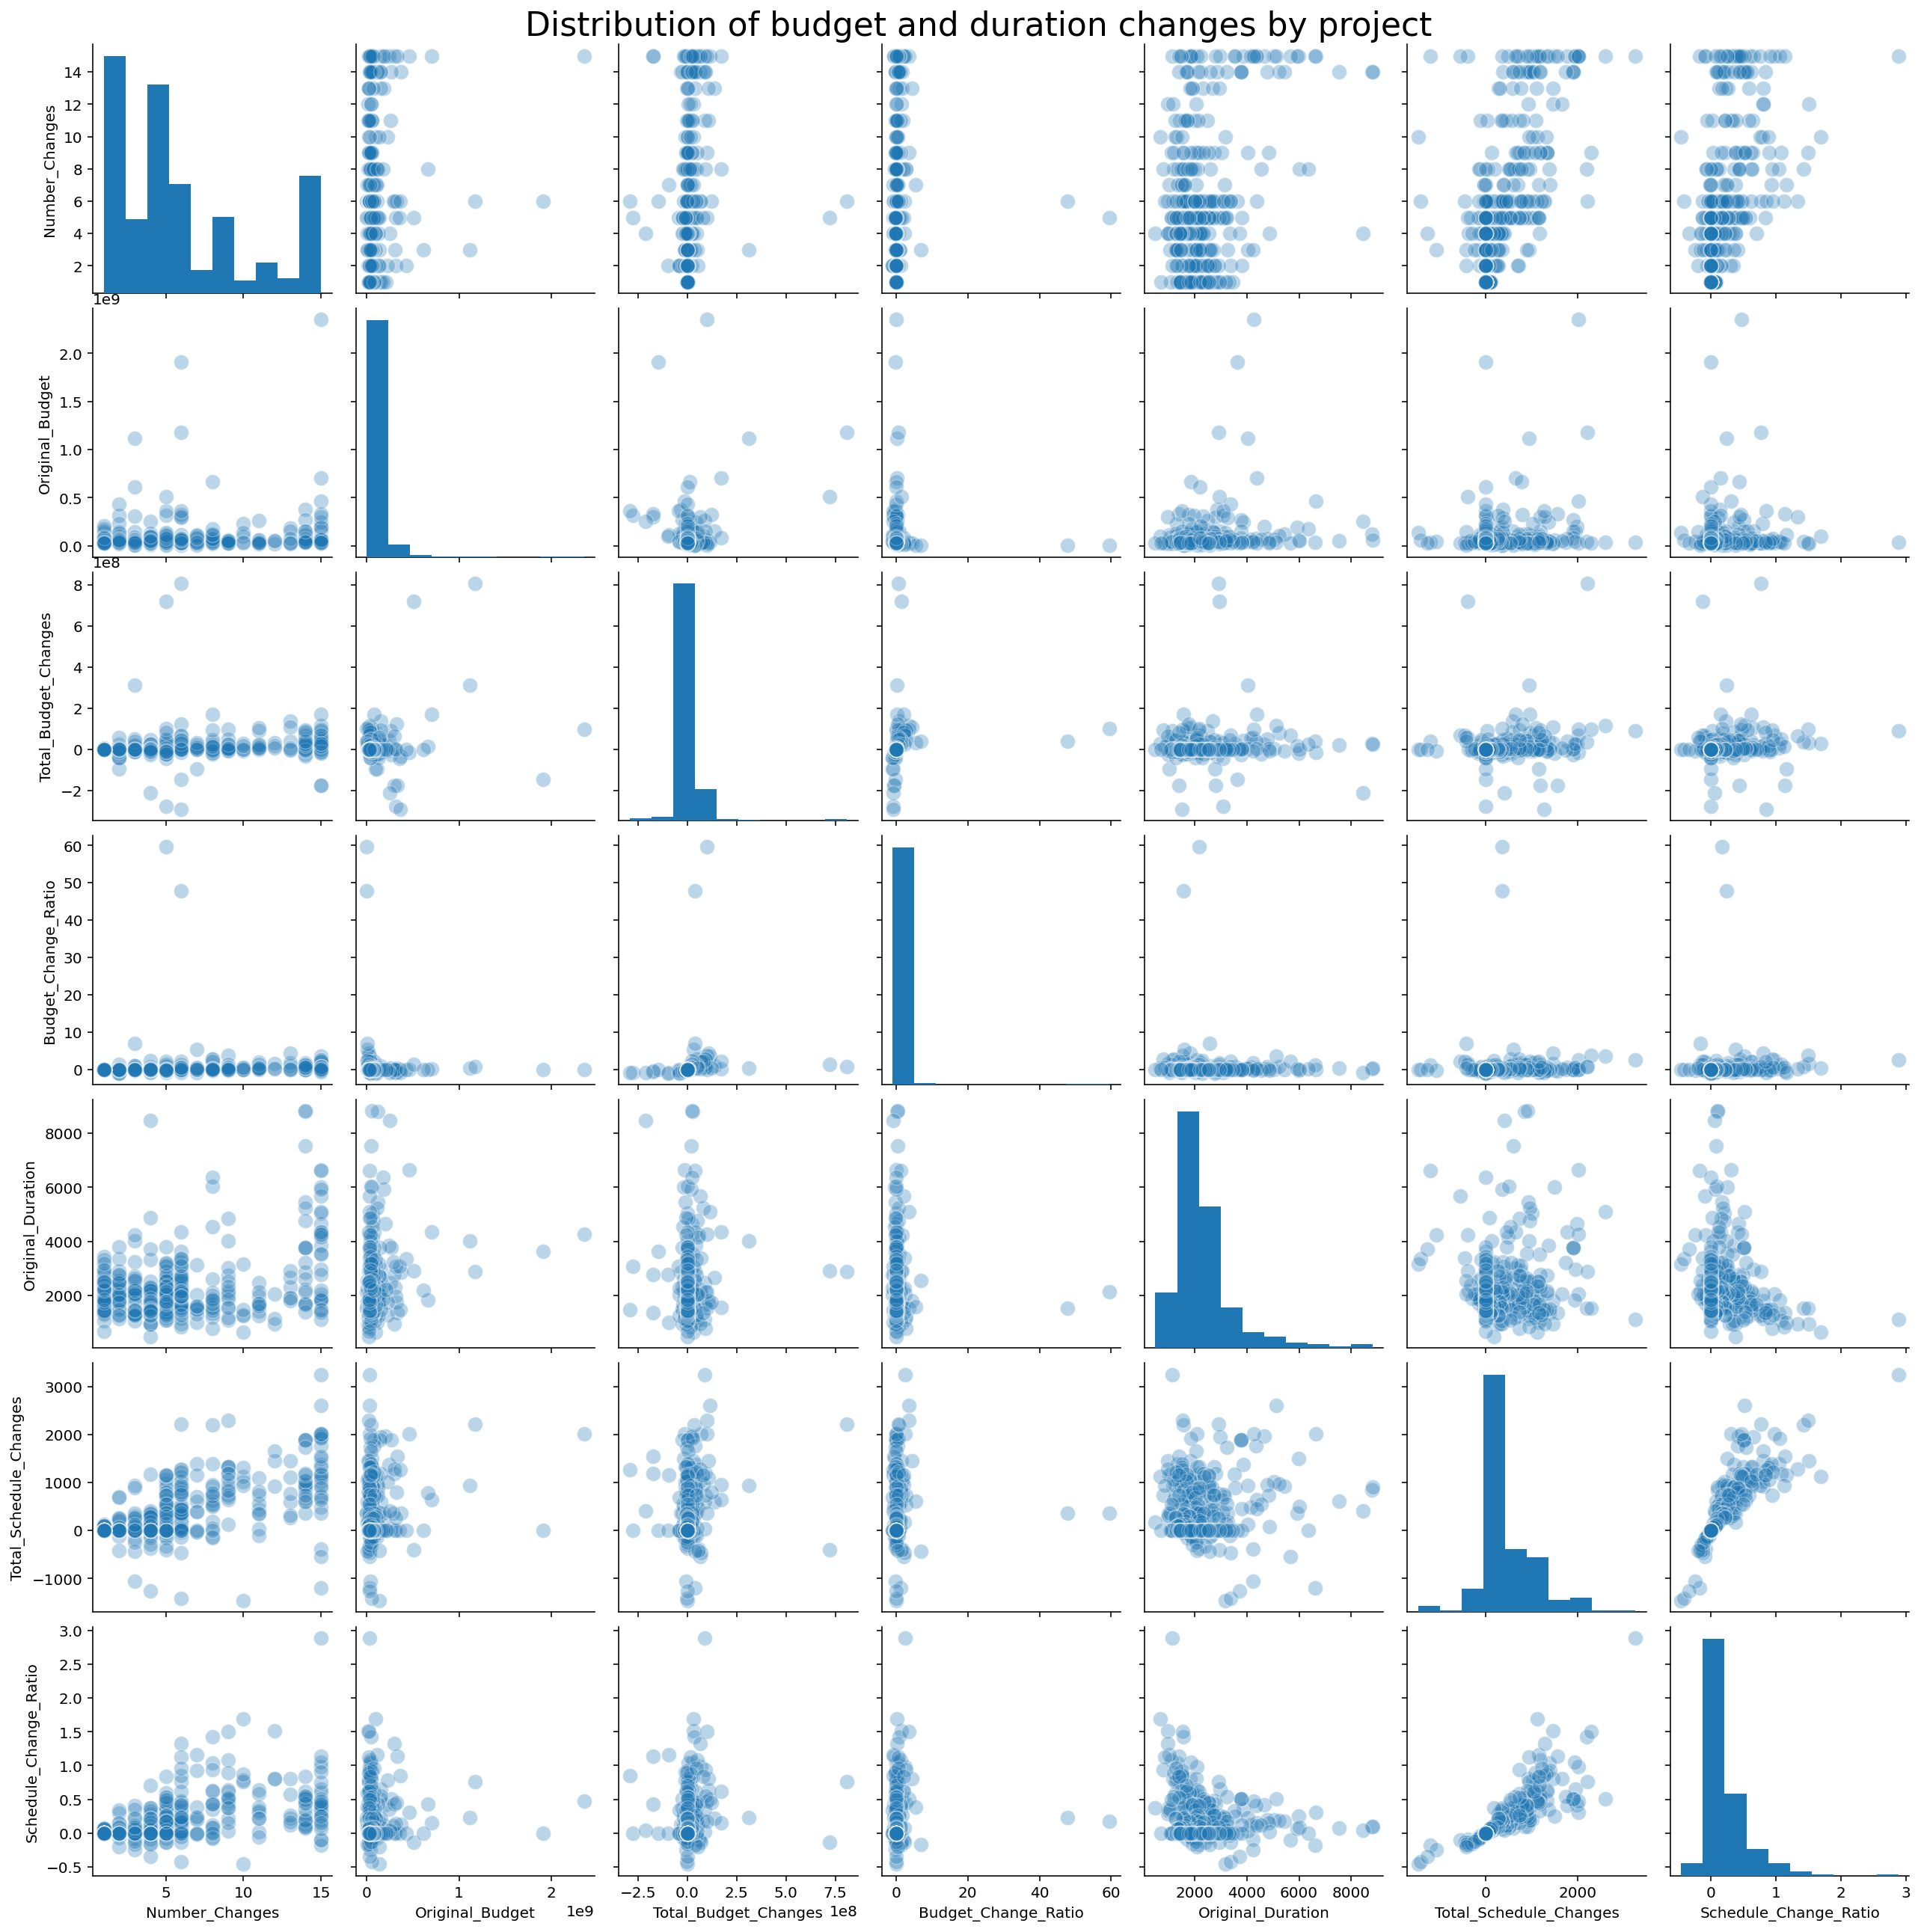

CPU times: user 17.7 s, sys: 231 ms, total: 17.9 s
Wall time: 9.09 s


In [48]:
%%time

# generate scatter matrix with each quantitative metric
scatter_cols = [
    'Number_Changes',
    'Original_Budget',
    'Total_Budget_Changes',
    'Budget_Change_Ratio',
    'Original_Duration',
    'Total_Schedule_Changes',
    'Schedule_Change_Ratio'
]

g = sns.pairplot(df_pid[scatter_cols], plot_kws={'alpha': 0.3, 's': 100})
g.fig.suptitle('Distribution of budget and duration changes by project', fontsize=22, y=1.015)
plt.show();

<br/>

**OBSERVATIONS:**

The above scatter matrix demonstrates, on a project-by-project basis, the correlation between quantitative features associated with each of the 355 unique projects that remain in the dataset. Of greatest interest here are relationships between the various "project change"-related measurements associated with each project. Of additional concern is the relative scale (in terms of budget and schedule duration) of the various projects measured.

In the subplots above, while there appears to be slight linear relationships between several features -- most notably the relationships between *total schedule change (in days)* and *schedule change ratio*, as well as *number of project changes* versus *schedule*-related metrics -- many of these relationships have fairly extreme outlying projects, which may obscure more nuanced relationships by compressing the majority of data points along either the $x$ or $y$ axes. The various relationships plotted against the *budget* and *budget change* features clearly exhibit this outlier behavior.

While the removal of these outliers and closer examination of non-outlying datapoints does warrant additional investigation, the remainder of this "change trend" analysis will instead focus on projects with extreme budget and schedule characteristics.

To do this, we will next look a little more closely at the distributions of *budget*- and *schedule*-related measures by project to identify some of the projects with these "extreme" measures.

<br/>

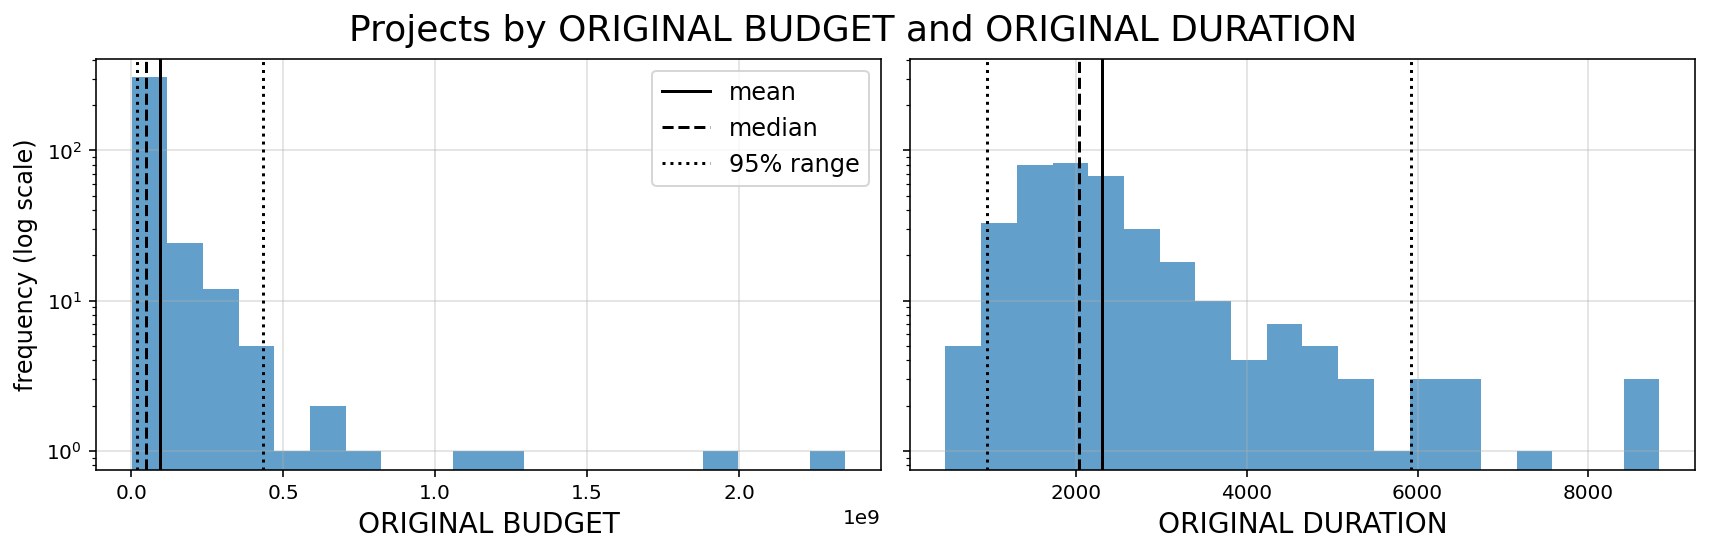

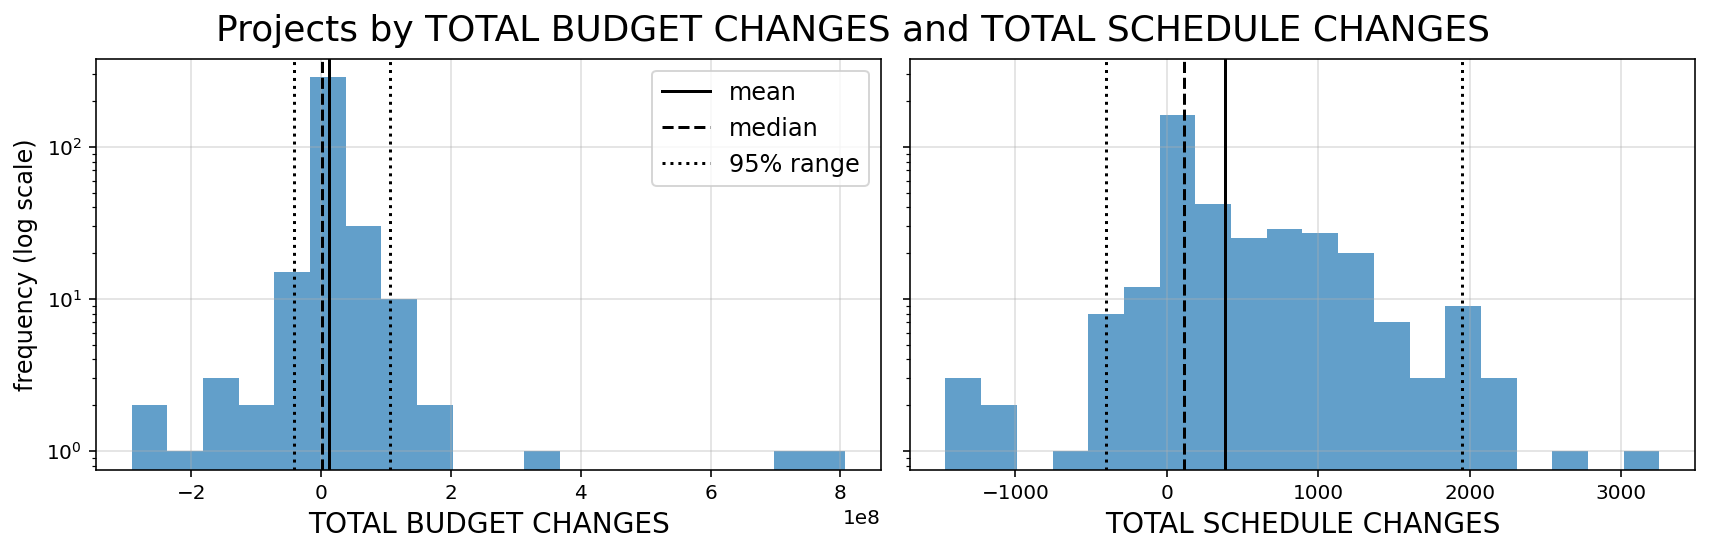

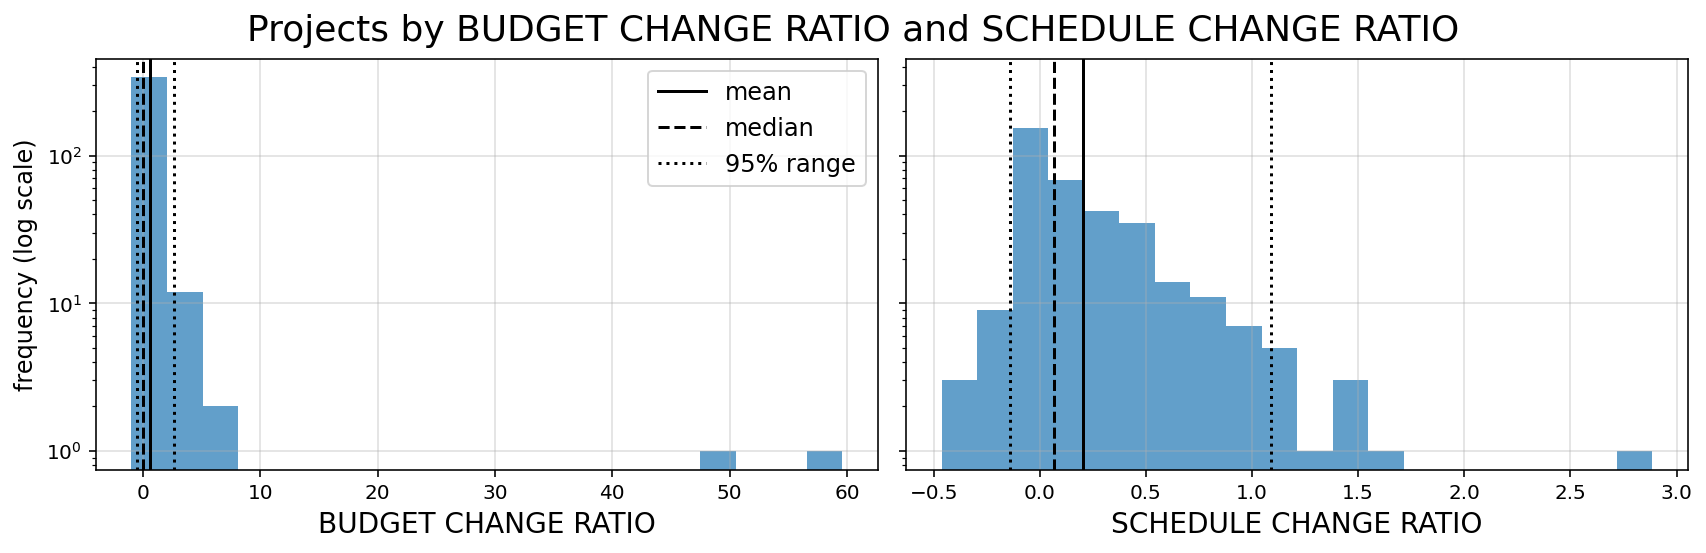

In [49]:
plot_hist_comps(df_pid, 'Original_Budget', 'Original_Duration', y_log=True)
plot_hist_comps(df_pid, 'Total_Budget_Changes', 'Total_Schedule_Changes', y_log=True)
plot_hist_comps(df_pid, 'Budget_Change_Ratio', 'Schedule_Change_Ratio', y_log=True)

<br/>

**OBSERVATIONS:**

As can be seen in the paired histogram plots above, most features exhibit distinct right-skewed distributions among projects. Most notably, among the "original" budget and duration as well as the "change ratios" for both budget and duration, clear outliers exist at extremely high values (these ratios are defined as the "total changes" divided by the "original" values for each project).

While a more in-depth statistical analysis will be needed to explore the aggregate change trends among all projects measured, for the purpose of this initial EDA, we will just visually inspect the time-series changes that have taken place among some of these more "extreme" projects below.

<br/>

### Investigate change trends by project for extreme changes or extreme original scope values

In [50]:
def identify_edge_pids(df, metric_col, n_pids=2,
                       change_threshold=5, change_col='Number_Changes'):
    """Identifies PIDs with minimum and maximum values for any given metric
    """
    loc_filter = df[change_col]>=change_threshold
    max_pids = list(
        df.loc[loc_filter].sort_values(by=metric_col, ascending=True)[-n_pids:]['PID']
    )
    min_pids = list(
        df.loc[loc_filter].sort_values(by=metric_col, ascending=True)[:n_pids]['PID']
    )
    
    return {'min': min_pids, 'max': max_pids}

In [51]:
metric_col_list = [
    'Original_Budget',
    'Original_Duration',
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio',
]

change_threshold = 5

edge_pids_dict = {
    metric_col: identify_edge_pids(
        df_pid, metric_col, n_pids=2, change_threshold=change_threshold
    )
    for metric_col in metric_col_list
}

print(
    'Projects with {} or more change records, and the largest and '\
    'smallest metric values are as follows:\n'.format(change_threshold)
)

for key, value in edge_pids_dict.items():
    print('{}\n'.format(key))
    for edge, pid_list in value.items():
        print('{}:\t{}'.format(edge, pid_list))
    print()

Projects with 5 or more change records, and the largest and smallest metric values are as follows:

Original_Budget

min:	[603, 784]
max:	[555, 416]

Original_Duration

min:	[480, 507]
max:	[96, 112]

Budget_Change_Ratio

min:	[537, 594]
max:	[603, 784]

Schedule_Change_Ratio

min:	[482, 690]
max:	[480, 193]



### Time series plots for projects with extreme changes or extreme original scope values

### Largest *Budget Change* and *Schedule Change*  ratios

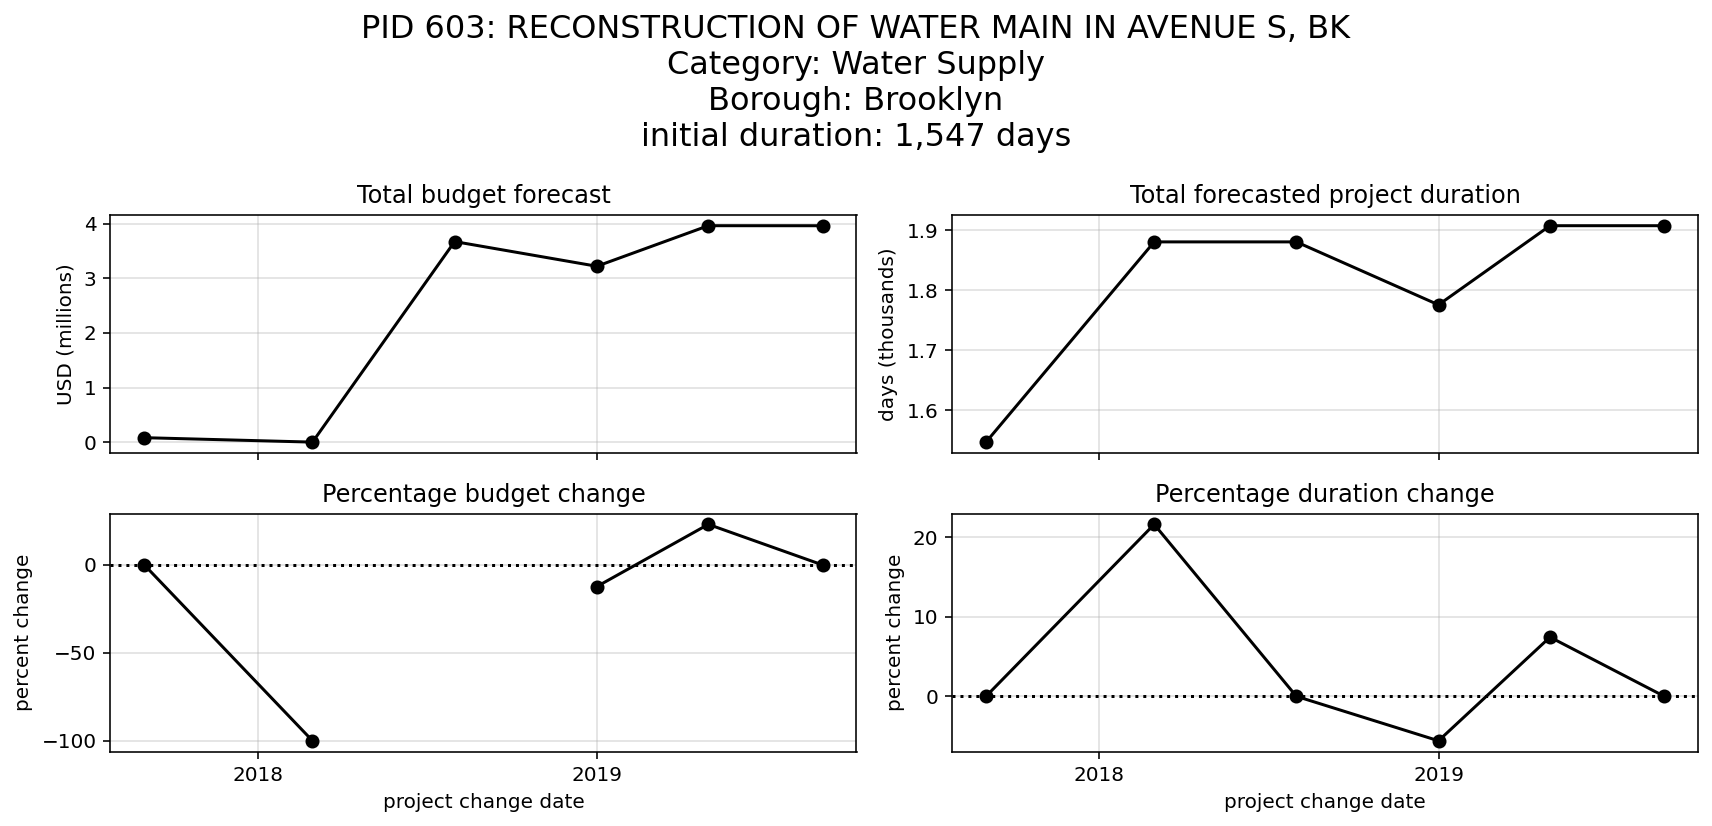

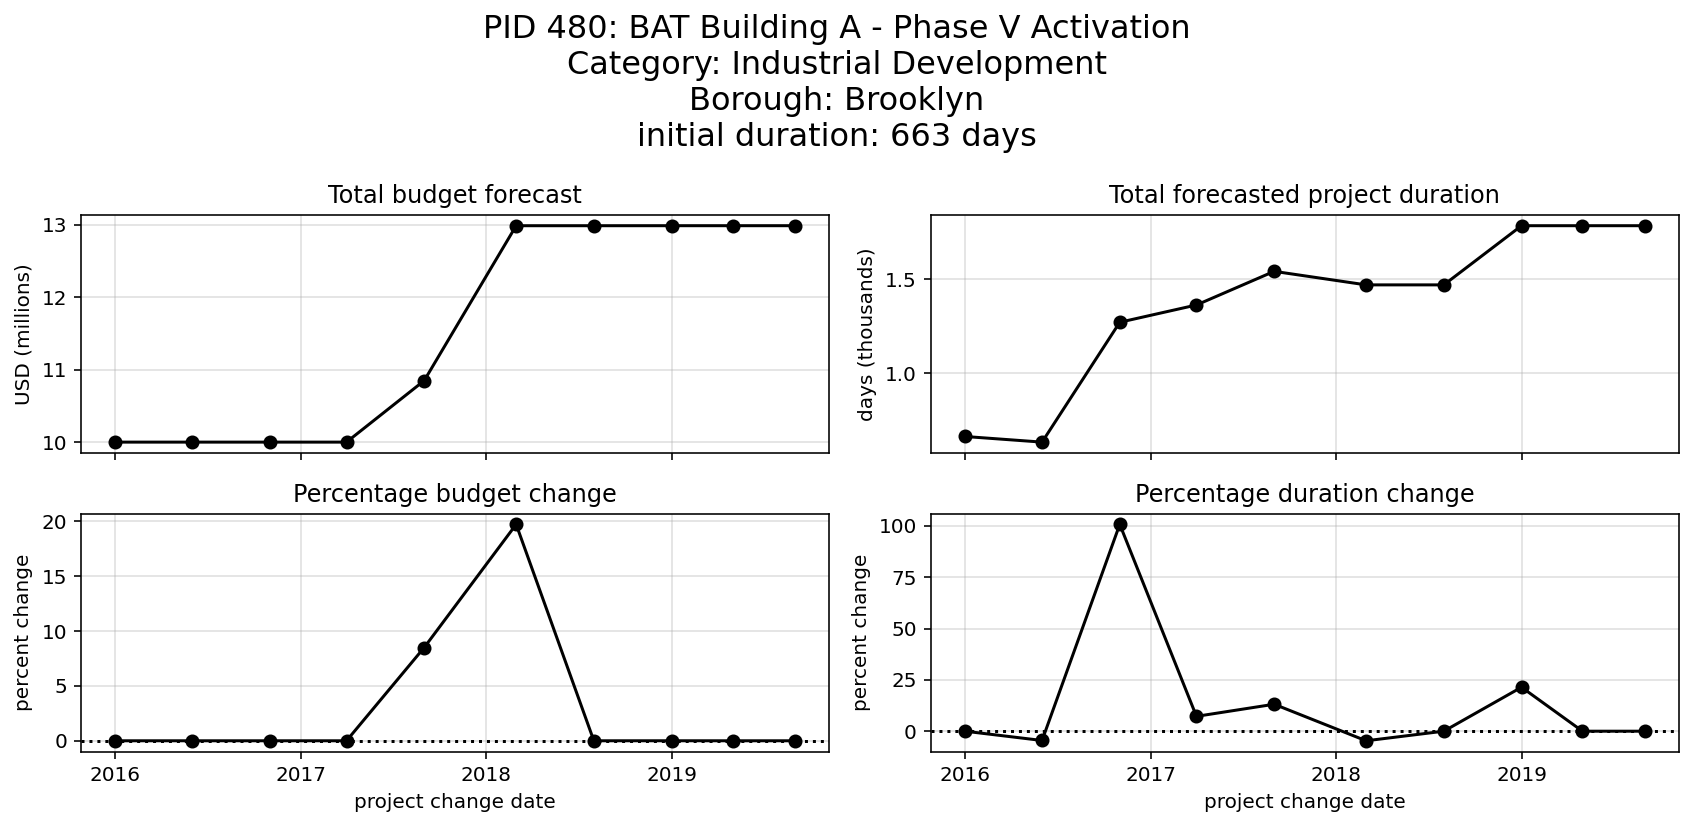

In [52]:
plot_change_trend(data, df_pid, 603)
plot_change_trend(data, df_pid, 480)

<br/>

The two projects plotted above represent:

1. **PID 603:** The **smallest** *Original Budget* and **largest** *Budget Change Ratio*


2. **PID 480:** The **shortest** *Original Scheduled Duration* and **largest** *Schedule Change Ratio*

<br/>

**OBSERVATIONS:**

In the case of both these projects, extremely large re-forecasts in budget and schedule were made during the life of the projects. Conversely, both started with extremely small forecasts relative to other projects in this dataset. In both these cases, we are led to question the validity of the original scopes for both projects. Either that, or perhaps significant additional scope was added to each project after the original design was completed.  

<br/>

### Largest *Original Budget*

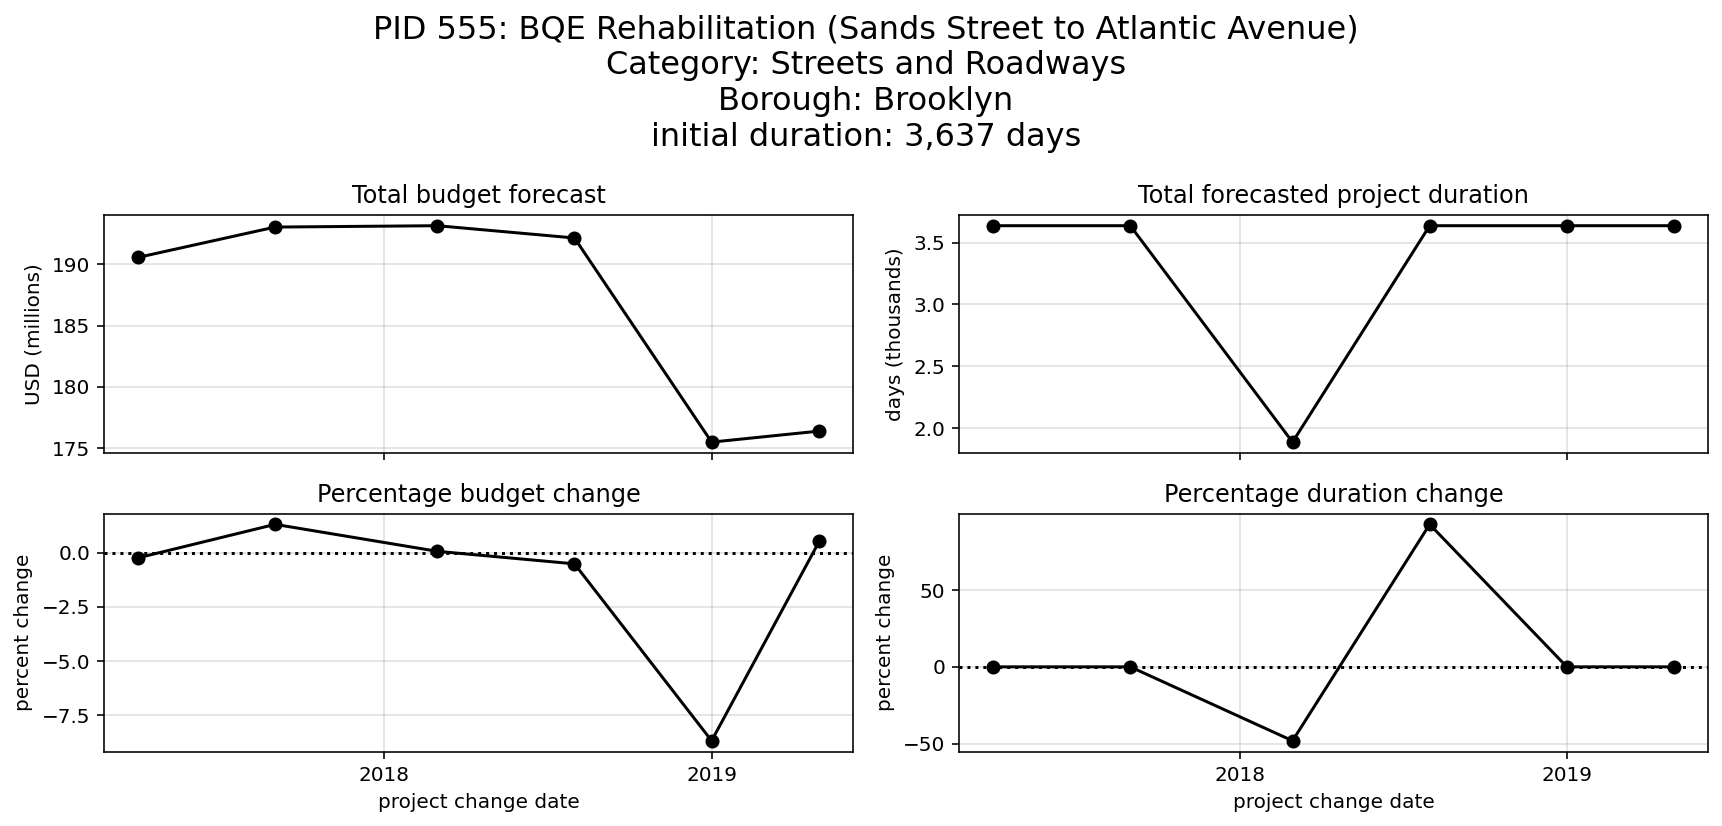

In [53]:
plot_change_trend(data, df_pid, 555)

<br/>

The project above represents:


3. **PID 555:** The **largest** *Original Budget*

<br/>

**OBSERVATIONS:**

It the above project change timeline, it is interesting to note the overall reduction in budget forecast over time, as well as the erratic short-term reduction in forecasted duration. Additional information on a project such as this would be of interest to understand the temporary reduction in hours by more that 1,500 days.

<br/>

### Longest *Original Scheduled Duration*

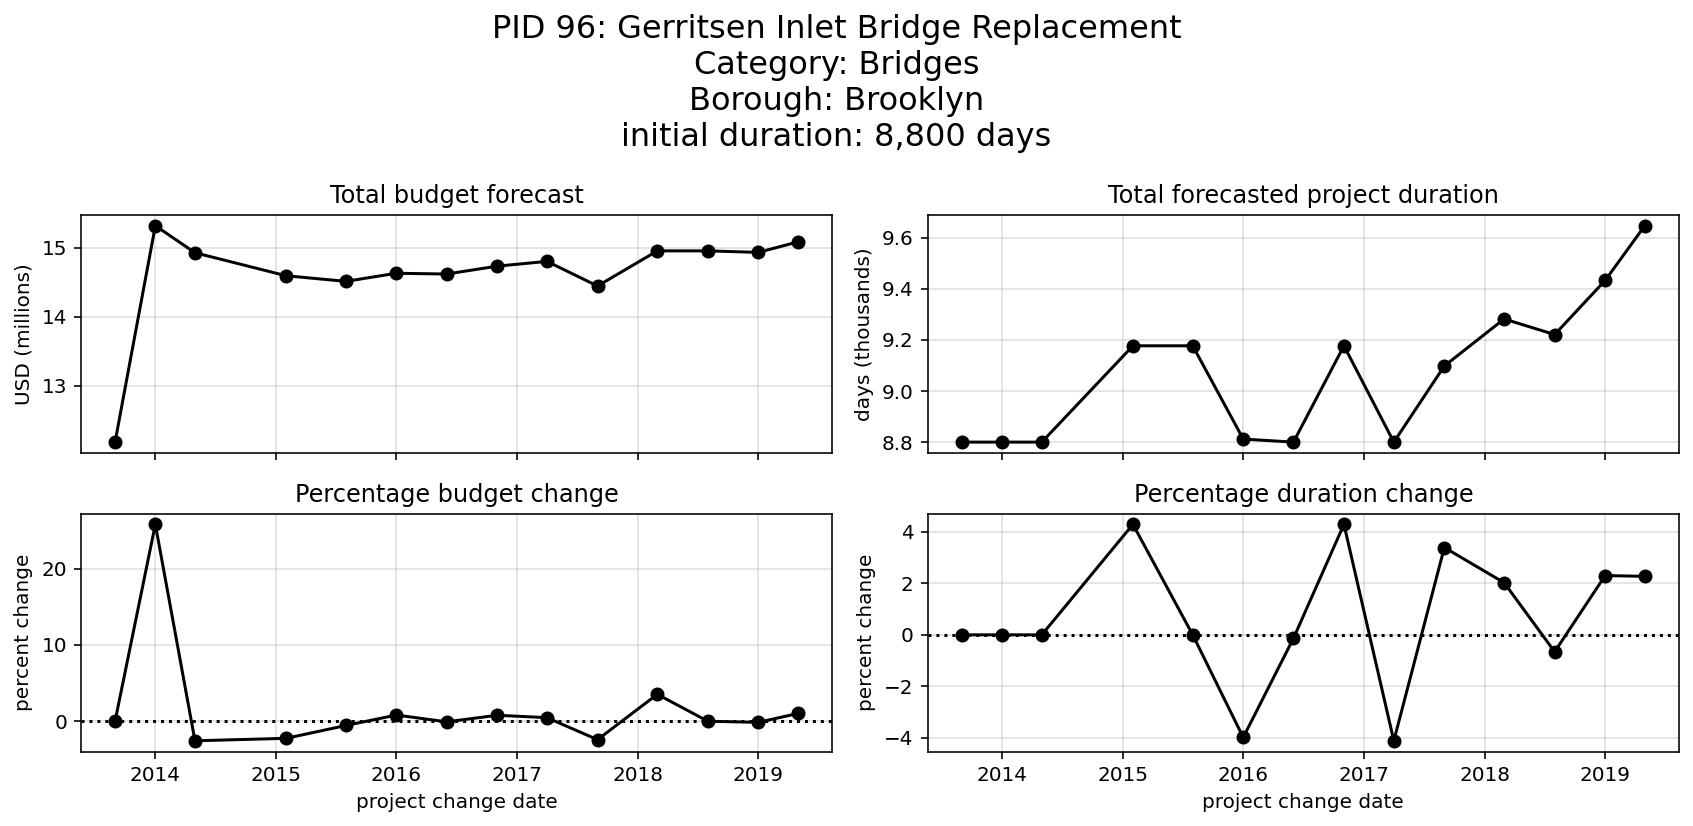

In [54]:
plot_change_trend(data, df_pid, 96)

<br/>

The project above represents:


4. **PID 96:** The **longest** *Original Scheduled Duration*

<br/>

**OBSERVATIONS:**

Althought this project began as the project with the longest original scheduled duration, at more than 8,800 days, it is intersting to note that this scope has still increased by an additional 1,800 days.

<br/>

### Smallest *Budget Change* and *Schedule Change* Ratios

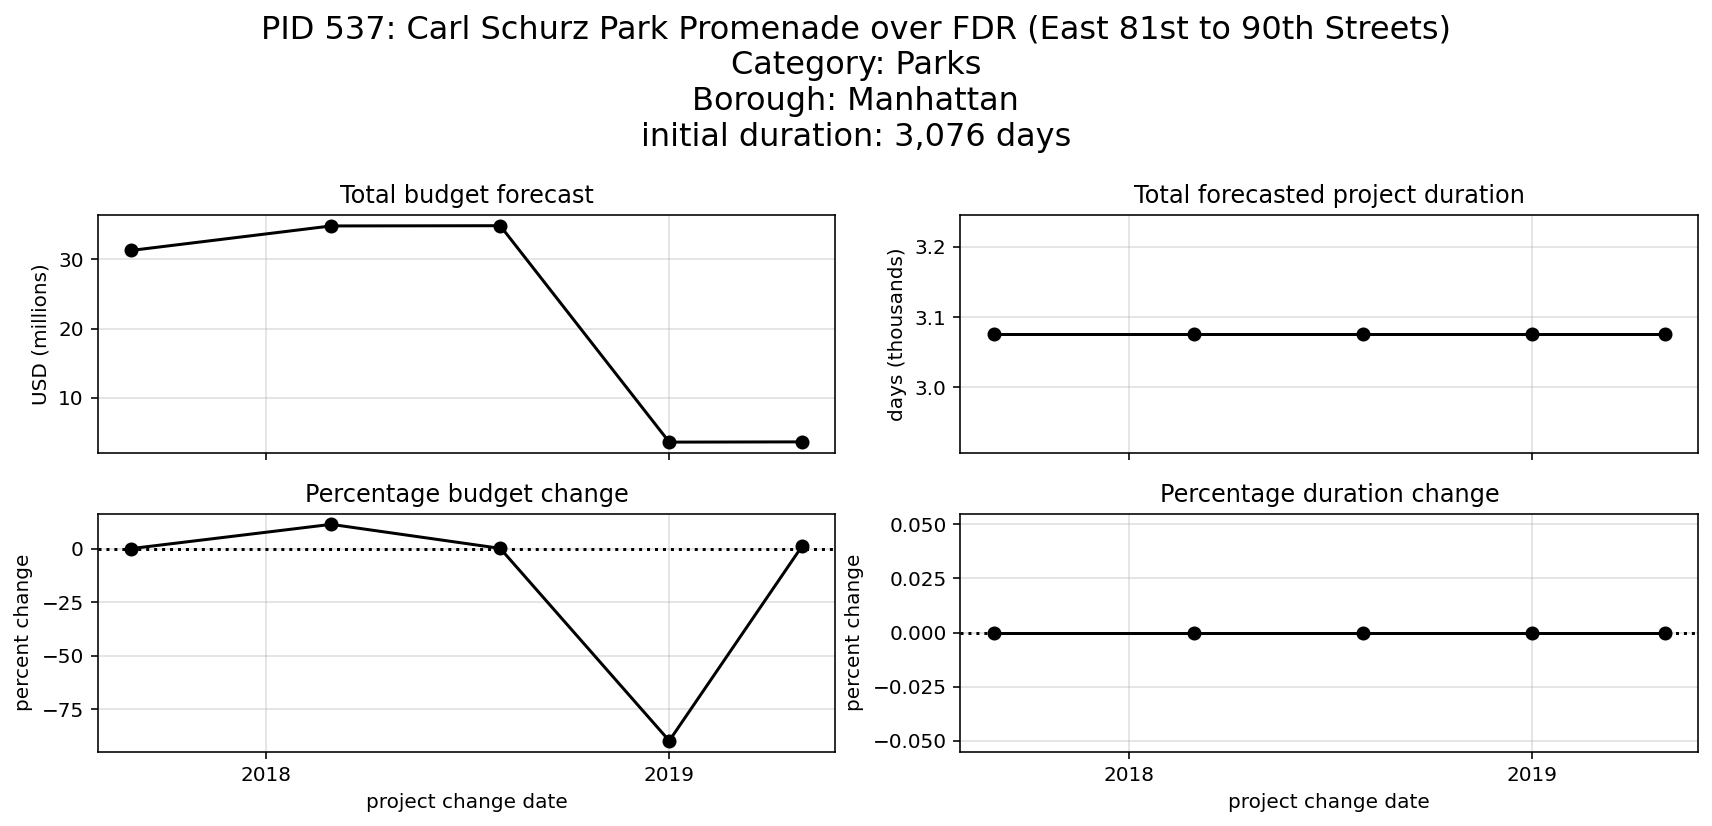

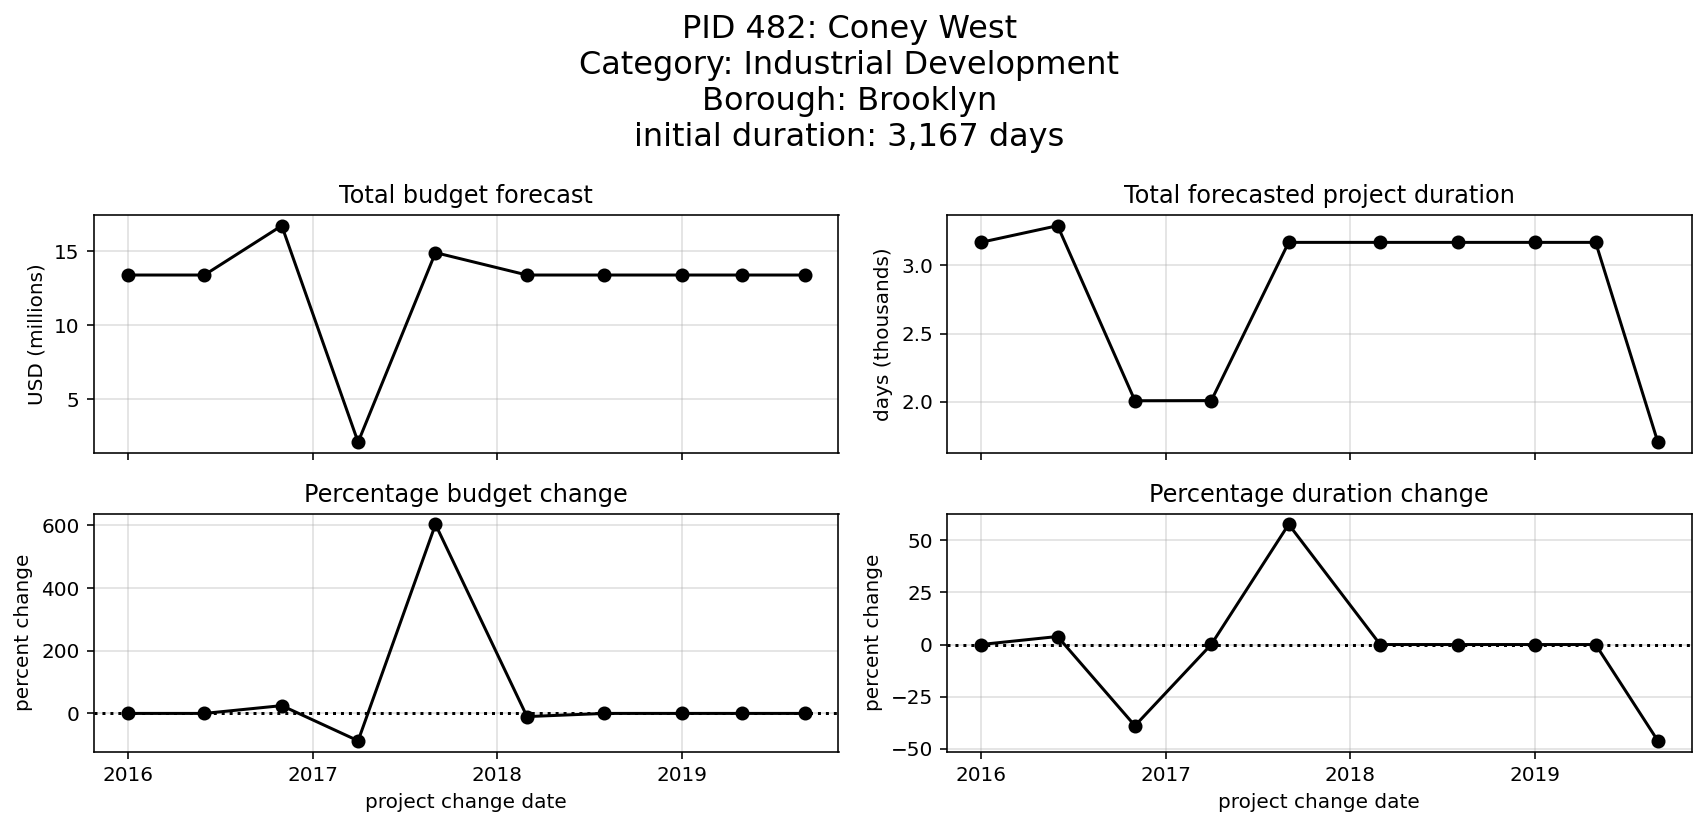

In [55]:
plot_change_trend(data, df_pid, 537)
plot_change_trend(data, df_pid, 482)

<br/>

The project above represents:

5. **PID 537:** The **smallest** *Budget Change Ratio*

6. **PID 482:** The **smallest** *Schedule Change Ratio*

<br/>

**OBSERVATIONS:**

Both of the above plots exhibit fairly extreme reductions in scope over the life of the project. PID 537 decreased in budget forecast from more than \\$30 million to less than \\$5 million with no corresponding reduction in scheduled duration. The second, PID 482, exhibited a reduction in scheduled duration from more than 3,000 days, to fewer than 2,000 days, but only temporarily exhibited a reduction in forecasted budget.

**CONCERNS:**

These two projects, as well as the others examined above, leads us to wonder the validity of some of the measures reported in this data, as well as the confounding factors that may also be influencing some of these changes in scope and forecast.

<br/>

<a name='budget'></a>
## Budget Values

<a href=#index>index</a>

### Stationary budget values (originally forecasted vs to date)

Metrics calculated:

- Absolute percentage error: |Forecast − Actual|/Actual
- Relative percentage error: (referred to as cost escalation in project estimation literature): |Forecast − Actual|/Forecast:
- Ratios: Forecast/Actual or Actual/Forecast Difference: Actual − Forecast
- Days delayed (only the positive differences) Absolute error: |Forecast − Actual| Squared error: (Forecast − Actual)2

In [56]:
df_pid = df_pid.eval('Budget_To_Date = Original_Budget + Total_Budget_Changes')\
            .eval('Budget_Abs_Per_Error = abs(Original_Budget - Budget_To_Date)/Budget_To_Date')\
            .eval('Budget_Rel_Per_Error = abs(Original_Budget - Budget_To_Date)/Original_Budget')\
            .eval('Mark_Metric = (Original_Budget/Budget_To_Date) - 1')\
            .eval('Budget_Ratios = Budget_To_Date/Original_Budget')
df_pid

,PID,Project_Name,Category,Borough,Managing_Agency,Client_Agency,Number_Changes,Original_Budget,Design_Start,Original_Schedule,...,Total_Schedule_Changes,Total_Budget_Changes,Original_Duration,Budget_Change_Ratio,Schedule_Change_Ratio,Budget_To_Date,Budget_Abs_Per_Error,Budget_Rel_Per_Error,Mark_Metric,Budget_Ratios
0,3,26th Ward Waste Water Treatment Plant Prelimin...,Wastewater Treatment,Brooklyn,DEP,DEP,13,"184,896,360.00",2013-09-23,2020-01-13,...,270.00,"-4,318,643.37","2,303.00",-0.02,0.12,"180,577,716.63",0.02,0.02,0.02,0.98
1,7,Bowery Bay Waste Water Treatment Plant Main Se...,Wastewater Treatment,Queens,DEP,DEP,15,"53,493,000.00",2013-05-01,2018-03-31,...,685.00,"15,305,457.00","1,795.00",0.29,0.38,"68,798,457.00",0.22,0.29,-0.22,1.29
2,18,Croton Falls Pumping Station Construction,Water Supply,Carmel,DEP,DEP,15,"66,616,435.00",2003-08-22,2017-05-31,...,"1,014.00","1,255,175.02","5,031.00",0.02,0.20,"67,871,610.02",0.02,0.02,-0.02,1.02
3,25,Gowanus Facilities Upgrade,Wastewater Treatment,Brooklyn,DEP,DEP,15,"198,134,067.00",2001-11-01,2014-08-05,...,"1,974.00","25,233,101.11","4,660.00",0.13,0.42,"223,367,168.11",0.11,0.13,-0.11,1.13
4,34,Jamaica Waste Water Treatment Plant Upgrades,Wastewater Treatment,Queens,DEP,DEP,15,"463,790,739.00",1996-05-01,2014-07-01,...,"2,009.00","-14,632,471.11","6,635.00",-0.03,0.30,"449,158,267.89",0.03,0.03,0.03,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,1010,PRIOR NOTICE SIDEWALKS - BROOKLYN,Streets and Roadways,not_specified,DDC,DOT,1,"29,427,000.00",2015-08-06,2020-05-13,...,0.00,0.00,"1,742.00",0.00,0.00,"29,427,000.00",0.00,0.00,0.00,1.00
359,1011,"RECONSTRUCTION OF ROSEDALE AREA, PHASE 2",Streets and Roadways,not_specified,DDC,DOT,1,"39,360,000.00",2018-06-07,2024-08-14,...,0.00,0.00,"2,260.00",0.00,0.00,"39,360,000.00",0.00,0.00,0.00,1.00
360,1012,"RECONSTRUCTION OF FRONT STREET, MANHATTAN",Streets and Roadways,not_specified,DDC,DOT,1,"27,356,000.00",2015-07-31,2022-06-16,...,0.00,0.00,"2,512.00",0.00,0.00,"27,356,000.00",0.00,0.00,0.00,1.00
361,1013,"GRAND CONCOURSE, PHASE 5",Streets and Roadways,not_specified,DDC,DOT,1,"78,921,000.00",2019-09-16,2025-09-13,...,0.00,0.00,"2,189.00",0.00,0.00,"78,921,000.00",0.00,0.00,0.00,1.00


In [57]:
df_pid_melted = df_pid.melt(id_vars=set(df_pid.columns) - set(["Budget_Abs_Per_Error", "Budget_Rel_Per_Error", 'Budget_Ratios', "Mark_Metric"]), value_vars=["Budget_Abs_Per_Error", "Budget_Rel_Per_Error", 'Budget_Ratios', "Mark_Metric"], var_name="metric", value_name="metric_value")
df_pid_melted


,Managing_Agency,PID,Original_Duration,Budget_To_Date,Total_Schedule_Changes,Design_Start,Client_Agency,Original_Budget,Category,Forecast_Completion,Project_Name,Original_Schedule,Borough,Total_Budget_Changes,Schedule_Change_Ratio,Number_Changes,Budget_Change_Ratio,metric,metric_value
0,DEP,3,"2,303.00","180,577,716.63",270.00,2013-09-23,DEP,"184,896,360.00",Wastewater Treatment,2020-10-09,26th Ward Waste Water Treatment Plant Prelimin...,2020-01-13,Brooklyn,"-4,318,643.37",0.12,13,-0.02,Budget_Abs_Per_Error,0.02
1,DEP,7,"1,795.00","68,798,457.00",685.00,2013-05-01,DEP,"53,493,000.00",Wastewater Treatment,2020-02-14,Bowery Bay Waste Water Treatment Plant Main Se...,2018-03-31,Queens,"15,305,457.00",0.38,15,0.29,Budget_Abs_Per_Error,0.22
2,DEP,18,"5,031.00","67,871,610.02","1,014.00",2003-08-22,DEP,"66,616,435.00",Water Supply,2020-03-10,Croton Falls Pumping Station Construction,2017-05-31,Carmel,"1,255,175.02",0.20,15,0.02,Budget_Abs_Per_Error,0.02
3,DEP,25,"4,660.00","223,367,168.11","1,974.00",2001-11-01,DEP,"198,134,067.00",Wastewater Treatment,2019-12-31,Gowanus Facilities Upgrade,2014-08-05,Brooklyn,"25,233,101.11",0.42,15,0.13,Budget_Abs_Per_Error,0.11
4,DEP,34,"6,635.00","449,158,267.89","2,009.00",1996-05-01,DEP,"463,790,739.00",Wastewater Treatment,2019-12-31,Jamaica Waste Water Treatment Plant Upgrades,2014-07-01,Queens,"-14,632,471.11",0.30,15,-0.03,Budget_Abs_Per_Error,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415,DDC,1010,"1,742.00","29,427,000.00",0.00,2015-08-06,DOT,"29,427,000.00",Streets and Roadways,2020-05-13,PRIOR NOTICE SIDEWALKS - BROOKLYN,2020-05-13,not_specified,0.00,0.00,1,0.00,Mark_Metric,0.00
1416,DDC,1011,"2,260.00","39,360,000.00",0.00,2018-06-07,DOT,"39,360,000.00",Streets and Roadways,2024-08-14,"RECONSTRUCTION OF ROSEDALE AREA, PHASE 2",2024-08-14,not_specified,0.00,0.00,1,0.00,Mark_Metric,0.00
1417,DDC,1012,"2,512.00","27,356,000.00",0.00,2015-07-31,DOT,"27,356,000.00",Streets and Roadways,2022-06-16,"RECONSTRUCTION OF FRONT STREET, MANHATTAN",2022-06-16,not_specified,0.00,0.00,1,0.00,Mark_Metric,0.00
1418,DDC,1013,"2,189.00","78,921,000.00",0.00,2019-09-16,DOT,"78,921,000.00",Streets and Roadways,2025-09-13,"GRAND CONCOURSE, PHASE 5",2025-09-13,not_specified,0.00,0.00,1,0.00,Mark_Metric,0.00


#### Comparing 3 budget metrics

In [58]:
px.histogram(df_pid_melted,x="metric_value", facet_col="metric", color="Category", barmode="overlay" )

### Budget Changes Time Series

In [59]:
fig = px.line(data.sort_values(['Date_Reported_As_Of', "PID"]), x='Date_Reported_As_Of', y="Latest_Budget_Changes", color= "Category", line_dash="PID", hover_name="PID", height=1000)
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig

**OBSERVATION**

There's a few projects that have enormous changes and skew the plot, while others are more clustered

In [60]:
fig = px.line(data.sort_values(['Date_Reported_As_Of', "PID"]), x='Date_Reported_As_Of', y="Latest_Budget_Changes", facet_col = "Borough", color= "Category", hover_name="PID", line_group="PID", facet_col_wrap=5, height= 2000)
fig

**OBSERVATION:**
    
- Alot of the projects with big changes do not have `Borough` specified, so it's unlikely we could use it as predictor for budget/schedule changes
- Some Borough have only one Category of projects (Manhattan only has `Bridges`)
- We also looked at budget changes conditional on Managing Agency and Client Agency, but didn't include them to preserve clarity

<a name='summary'></a>
## Summary & Findings

<a href=#index>index</a>

- Poor data quality. The trend analyses for a handful of projects led us to wonder if the validity of some of the measures reported in this data, as well as the confounding factors that may also be influencing some of these changes in scope and forecast.

- Data is inconsistent in quality. Human-entered data will always have inconsistencies. We will need to work around or with that.

- Any model will need more data. We will need to source more project data from other regions and types of projects to increase the variety

- Lots of missing data. Any analyses would have to dive into the various biases that removing the missing data entails

- To feed a model, some data engineering will be necessary. The types of dat that need to be created are not yet understood.

- Any efforts to normalize data will need to consider normalization within the project as well as within the entire dataset.



## Key Questions

**Given everything you have learned, if you faced this data set in the wild, how would you proceed?**

- Need to do some investigations on some of the projects and their budget/schedule deviations. Simply removing the projects with seemingly erroneous or inconsistent data could lead to a biased dataset.

- Find secondary sources of data on the projects/agencies and management practices, how data is collected and incentive systems.

- Collect information on how the project management methodology in the specific reporting agencies.


**What are the important measures?**

- Actual vs initally planned project costs and duration.


**What are the right questions to ask, and how can the data answer them?**

- Are there any quantitative indicators at the beginning of the project that would help us predict the risk of cost and time overrun?

- Are there indicators during the life cycle of a project that would help us predict the risk of cost and time overrun?


**The data we have right now is insufficient to answer these questions. All of the projects we currently have data for have not finished.**

Additional data that we need would be:

- Information about finished projects.
- Text: Potential unstructured text sources like project plans, project review, project contracts.
- Key players at the management level, clients, organizations, vendors.
- Labor and materials percentages of total cost.
- Engineering complexity.
- Sources/Agencies of funding.
- Geographical locations of the delivered projects, geographical characteristics.


<a name='save'></a>

## Save dataframes to .csv

Save resulting dataframes to .csv for further analysis

<a href=#index>index</a>

In [61]:
print(
    'The resulting dataframes will be saved to .csv at the following path locations:\n'
)
for save_path in [save_path_cleansed, save_path_pid, save_path_melted]:
    print(save_path)

The resulting dataframes will be saved to .csv at the following path locations:

../data/interim/Capital_Projects_clean.csv
../data/interim/Capital_Projects_pid.csv
../data/interim/Capital_Projects_melted.csv


In [62]:
data.to_csv(save_path_cleansed, index=False)
df_pid.to_csv(save_path_pid, index=False)
df_pid_melted.to_csv(save_path_melted, index=False)

In [65]:
data.head(3)

,Date_Reported_As_Of,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Current_Phase,Design_Start,Original_Budget,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Original_Schedule,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes
0,2014-05-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,2-Design,2013-09-23,"184,896,360.00","182,980,960.00","-1,915,400.00","-4,318,643.37",2020-01-13,2020-01-14,1.00,270.00
1,2015-02-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,3-Construction Procurement,2013-09-23,"184,896,360.00","168,751,769.00","-14,229,191.00","-4,318,643.37",2020-01-13,2020-07-19,187.00,270.00
2,2015-08-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,3-Construction Procurement,2013-09-23,"184,896,360.00","165,532,447.00","-3,219,322.00","-4,318,643.37",2020-01-13,2020-08-08,20.00,270.00


In [66]:
data['Date_Reported_As_Of'].describe()

count                    2150
unique                     15
top       2019-05-01 00:00:00
freq                      296
first     2013-09-01 00:00:00
last      2019-09-01 00:00:00
Name: Date_Reported_As_Of, dtype: object

In [68]:
df_pid.head(3)

,PID,Project_Name,Category,Borough,Managing_Agency,Client_Agency,Number_Changes,Original_Budget,Design_Start,Original_Schedule,...,Total_Schedule_Changes,Total_Budget_Changes,Original_Duration,Budget_Change_Ratio,Schedule_Change_Ratio,Budget_To_Date,Budget_Abs_Per_Error,Budget_Rel_Per_Error,Mark_Metric,Budget_Ratios
0,3,26th Ward Waste Water Treatment Plant Prelimin...,Wastewater Treatment,Brooklyn,DEP,DEP,13,"184,896,360.00",2013-09-23,2020-01-13,...,270.00,"-4,318,643.37","2,303.00",-0.02,0.12,"180,577,716.63",0.02,0.02,0.02,0.98
1,7,Bowery Bay Waste Water Treatment Plant Main Se...,Wastewater Treatment,Queens,DEP,DEP,15,"53,493,000.00",2013-05-01,2018-03-31,...,685.00,"15,305,457.00","1,795.00",0.29,0.38,"68,798,457.00",0.22,0.29,-0.22,1.29
2,18,Croton Falls Pumping Station Construction,Water Supply,Carmel,DEP,DEP,15,"66,616,435.00",2003-08-22,2017-05-31,...,"1,014.00","1,255,175.02","5,031.00",0.02,0.20,"67,871,610.02",0.02,0.02,-0.02,1.02


In [96]:
(data['Date_Reported_As_Of'] - data['Design_Start']).dt.days / 365.2425

0       0.60
1       1.36
2       1.85
3       2.27
4       2.69
        ... 
2254    4.07
2255    1.23
2256    4.09
2257   -0.04
2258    0.03
Length: 2150, dtype: float64

In [112]:
drop_pid_list = [pid[0] for pid in drop_pids]

In [113]:
drop_pid_list

[863, 910, 267, 403, 553, 723, 863, 910, 911, 1006]

In [101]:
data.copy().loc[data['Date_Reported_As_Of'].isnull()]

,Date_Reported_As_Of,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Current_Phase,Design_Start,Original_Budget,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Original_Schedule,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes,Current_Project_Year


In [103]:
df_pid['PID']==911

0      False
1      False
2      False
3      False
4      False
       ...  
358    False
359    False
360    False
361    False
362    False
Name: PID, Length: 355, dtype: bool

In [104]:
data.copy().loc[data['Design_Start'].isnull()]['PID'].value_counts()

403    15
267    15
553     9
723     5
863     4
911     3
910     3
569     1
Name: PID, dtype: int64

In [115]:
data = data.copy().loc[~data['PID'].isin(drop_pid_list)]

In [116]:
data.copy().loc[data['Design_Start'].isnull()]['PID'].value_counts()

569    1
Name: PID, dtype: int64

,PID,Design_Start
0,3,2013-09-23
1,7,2013-05-01
2,18,2003-08-22
3,25,2001-11-01
4,34,1996-05-01
...,...,...
358,1010,2015-08-06
359,1011,2018-06-07
360,1012,2015-07-31
361,1013,2019-09-16


In [121]:
design_start_dict = {
    key: value for key, value in zip(df_pid['PID'], df_pid['Design_Start'].values)
}

In [123]:
data['Design_Start'] = data['PID'].copy().map(design_start_dict)

In [124]:
data.copy().loc[data['Design_Start'].isnull()]['PID'].value_counts()

Series([], Name: PID, dtype: int64)

In [125]:
data['Current_Project_Year'] = (data['Date_Reported_As_Of'] - data['Design_Start']).dt.days / 365.2425
data['Current_Project_Year_Rd'] = (
    (data['Date_Reported_As_Of'] - data['Design_Start']).dt.days / 365.2425
).astype(int)

In [85]:
df_pid['Project_Years'] = (data['Date_Reported_As_Of'].max() - df_pid['Design_Start']).dt.days / 365.2425

In [86]:
df_pid['Project_Years_Rd'] = ((data['Date_Reported_As_Of'].max() - df_pid['Design_Start']).dt.days / 365.2425).astype(int)

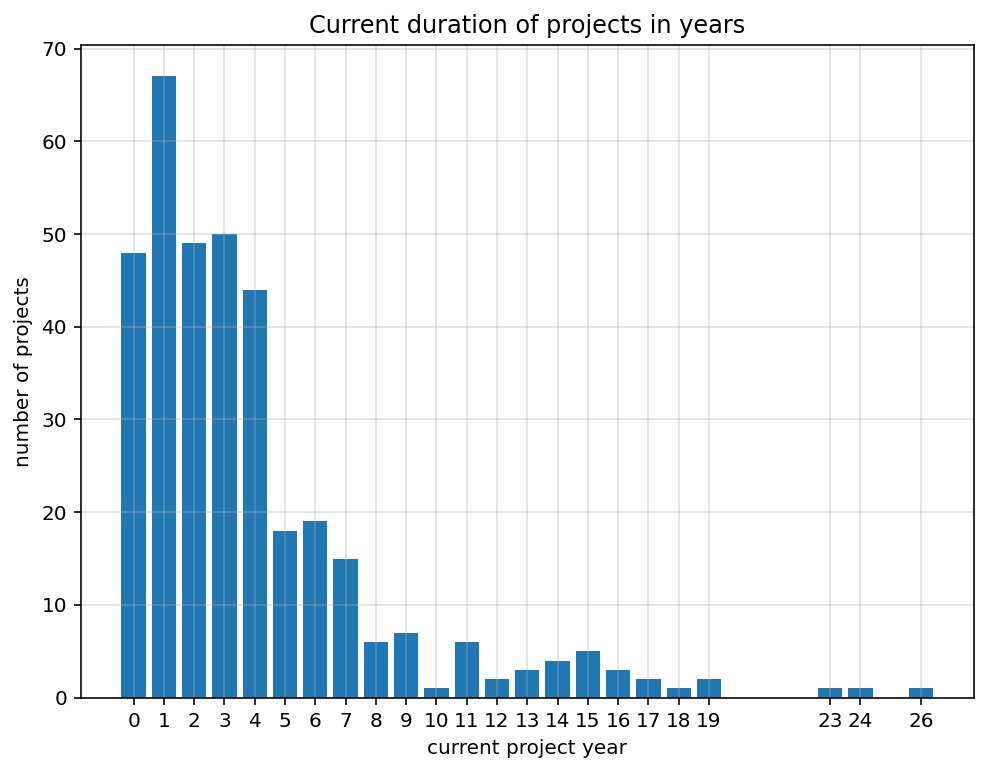

0     48
1     67
2     49
3     50
4     44
5     18
6     19
7     15
8      6
9      7
10     1
11     6
12     2
13     3
14     4
15     5
16     3
17     2
18     1
19     2
23     1
24     1
26     1
Name: Project_Years_Rd, dtype: int64


In [95]:
project_yrs = df_pid['Project_Years_Rd'].value_counts().sort_index()

plt.figure(figsize=(8,6))
plt.bar(project_yrs.index, project_yrs.values)
plt.title('Current duration of projects in years')
plt.grid(':', alpha=0.4)
plt.xticks(project_yrs.index)
plt.xlabel('current project year')
plt.ylabel('number of projects')
plt.show()

print(project_yrs)

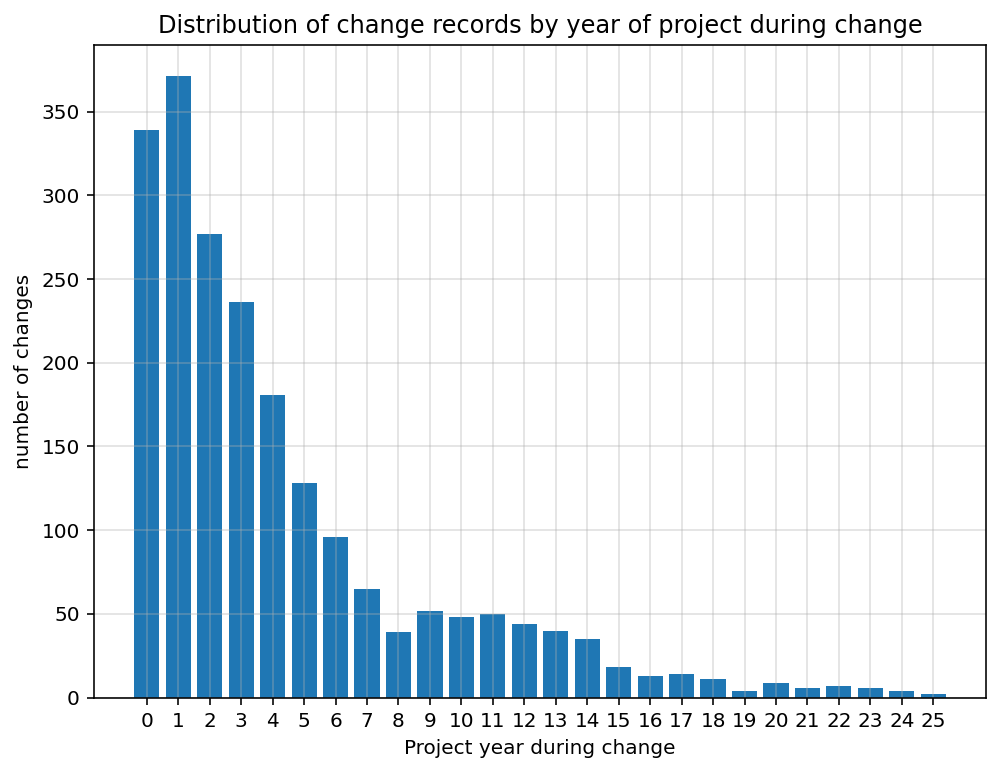

0     339
1     371
2     277
3     236
4     181
5     128
6      96
7      65
8      39
9      52
10     48
11     50
12     44
13     40
14     35
15     18
16     13
17     14
18     11
19      4
20      9
21      6
22      7
23      6
24      4
25      2
Name: Current_Project_Year_Rd, dtype: int64


In [127]:
change_yr = data['Current_Project_Year_Rd'].value_counts().sort_index()

plt.figure(figsize=(8,6))
plt.bar(change_yr.index, change_yr.values)
plt.title('Distribution of change records by year of project during change')
plt.grid(':', alpha=0.4)
plt.xticks(change_yr.index)
plt.xlabel('Project year during change')
plt.ylabel('number of changes')
plt.show()

print(change_yr)